In [0]:
import csv
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn import preprocessing

## 資料獲取

In [0]:
headers = {
    "User-Agent": "Googlebot"
}

In [0]:
# 商品名稱與連結
def goods(url):
  # allow_redirects=False 避免網站被重新導向
  resp = requests.get(url, headers=headers, allow_redirects=False)
  soup = BeautifulSoup(resp.text, "lxml")
  goods_item = soup.find_all("div", "col-xs-2-4 shopee-search-item-result__item")

  item_list = []
  for i in goods_item:
    item_list.append({
        "Title": i.find("div", "O6wiAW").getText(),
        "Link": "https://shopee.tw/" + i.find("a").get("href")
    })

  return item_list

In [0]:
# 獲取單個商品的資訊與店家資訊
def goods_info(goods_url):
  resp_goods = requests.get(goods_url, headers=headers, allow_redirects = False)
  soup = BeautifulSoup(resp_goods.text, "lxml")

  goods = {} # 儲存商品資訊(dict)
  goods["Title"] = soup.find("div", "qaNIZv").find("span").text # 商品名稱
  goods["Price"] = soup.find("div", "_3n5NQx").text.split(" -")[0].lstrip("$").replace(",","") # 價格
  # 品牌
  if soup.find("a", "_2H-513") != None:
    goods["Brand"] = soup.find("a", "_2H-513").text 
  else:
    goods["Brand"] = "其他"
  if "萬" in soup.find("div", "_22sp0A").text:
    goods["Sales_Volume"] = int(soup.find("div", "_22sp0A").text.split("萬")[0].replace(".",""))*10000
  else:
    goods["Sales_Volume"] = soup.find("div", "_22sp0A").text.replace(",","") # 銷售量
  # 評價星級 & 評價數量
  if soup.find("div", "_3Oj5_n") != None:
    if "萬" in soup.find_all("div", "_3Oj5_n")[1].text:
      goods["Reviews_Num"] = int(soup.find_all("div", "_3Oj5_n")[1].text.split("萬")[0].replace(".",""))*10000
    else:
      goods["Reviews_Num"] = soup.find_all("div", "_3Oj5_n")[1].text.replace(",","")
    goods["Star"] = soup.find("div", "_3Oj5_n _2z6cUg").text
  else:
    goods["Reviews_Num"] = 0
    goods["Star"] = 0

  # 賣家
  tmp = eval(soup.find_all("script")[1].getText()) # eval(): 把字串換成字典型式
  goods["Store_Name"] = tmp["offers"]["seller"]["name"]
  goods["Store_RateCount"] = tmp["offers"]["seller"]["aggregateRating"]["ratingCount"]
  goods["Store_RateValue"] = tmp["offers"]["seller"]["aggregateRating"]["ratingValue"]

  return goods

In [0]:
# 獲取單頁所有商品資訊
def get_goods(response):
  goods_detail_list = []

  for x in response:
    goods_detail = goods_info(x["Link"])
    goods_detail_list.append(goods_detail)
  
  return goods_detail_list

In [0]:
# 取得所有商品資料
goods_detail_list = []
goods_list_url = "https://shopee.tw/Android%E7%A9%BA%E6%A9%9F-cat.70.2609?newItem=true&officialMall=true&page="

for i in range(8):
  page_url = goods_list_url + str(i) + "&sortBy=pop"
  response = goods(page_url)
  goods_detail = get_goods(response)
  goods_detail_list.extend(goods_detail)

df = pd.DataFrame(goods_detail_list)
# print("總共印出%d筆" %(len(goods_detail_list)))

## 資料處理

In [0]:
# 換資料型態
df["Price"] = df["Price"].astype("int")
df["Brand"] = df["Brand"].astype("category")
df["Sales_Volume"] = df["Sales_Volume"].astype("int")
df["Reviews_Num"] = df["Reviews_Num"].astype("int")
df["Star"] = df["Star"].astype("float")
df["Store_RateCount"] = df["Store_RateCount"].astype("int")
df["Store_RateValue"] = df["Store_RateValue"].astype("float")

In [24]:
# 刪除未寫品牌資料的row
df = df[~df["Brand"].isin(["其他"])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 399
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Title            399 non-null    object  
 1   Price            399 non-null    int64   
 2   Brand            399 non-null    category
 3   Sales_Volume     399 non-null    int64   
 4   Reviews_Num      399 non-null    int64   
 5   Star             399 non-null    float64 
 6   Store_Name       399 non-null    object  
 7   Store_RateCount  399 non-null    int64   
 8   Store_RateValue  399 non-null    float64 
dtypes: category(1), float64(2), int64(4), object(2)
memory usage: 29.2+ KB


In [0]:
# 商品資料
df_goods = df[["Title", "Price", "Brand", "Sales_Volume", "Star", "Reviews_Num", "Store_Name"]]
# 商店資料
df_store = df[["Store_Name", "Store_RateCount", "Store_RateValue"]]
df_store = df_store.drop_duplicates().reset_index(drop=True)
# 品牌資料
groupB = df_goods.groupby("Brand")
df_brand = pd.DataFrame(groupB["Sales_Volume"].sum())
df_brand["Brand_Sales"] = groupB["Sales_Volume"].sum() # 銷售量
df_brand["Brand_Mean_Price"] = round(groupB["Price"].mean(),2) # 平均價格
df_brand["Brand_Mean_Star"] = round(groupB["Star"].mean(),1) # 平均評價星級
df_brand["Brand_Reviews_Num"] = groupB["Reviews_Num"].sum() # 評論數量
df_brand["Store_Num"] = groupB["Store_Name"].nunique() # 販售店家數量
df_brand.drop(columns=["Sales_Volume"], inplace=True)
df_brand.drop(["其他"], axis=0, inplace=True)

In [0]:
# 品牌資料標準化
df_brand_copy = df_brand.copy()
df_brand_copy["Brand_Mean_Price"] = df_brand_copy["Brand_Mean_Price"]*(-1)
min_max = preprocessing.MinMaxScaler(feature_range=(1, 10))
min_max_data = np.around(min_max.fit_transform(df_brand_copy), 2)
brand_process = pd.DataFrame(min_max_data, index=df_brand_copy.index, columns=df_brand_copy.columns)
brand_process["Nor_sum"] = brand_process.sum(axis=1)

## 視覺化分析

[Text(0, 0.5, 'Price'),
 Text(0, 1.5, 'Sales_Volume'),
 Text(0, 2.5, 'Reviews_Num'),
 Text(0, 3.5, 'Star'),
 Text(0, 4.5, 'Store_RateCount'),
 Text(0, 5.5, 'Store_RateValue')]

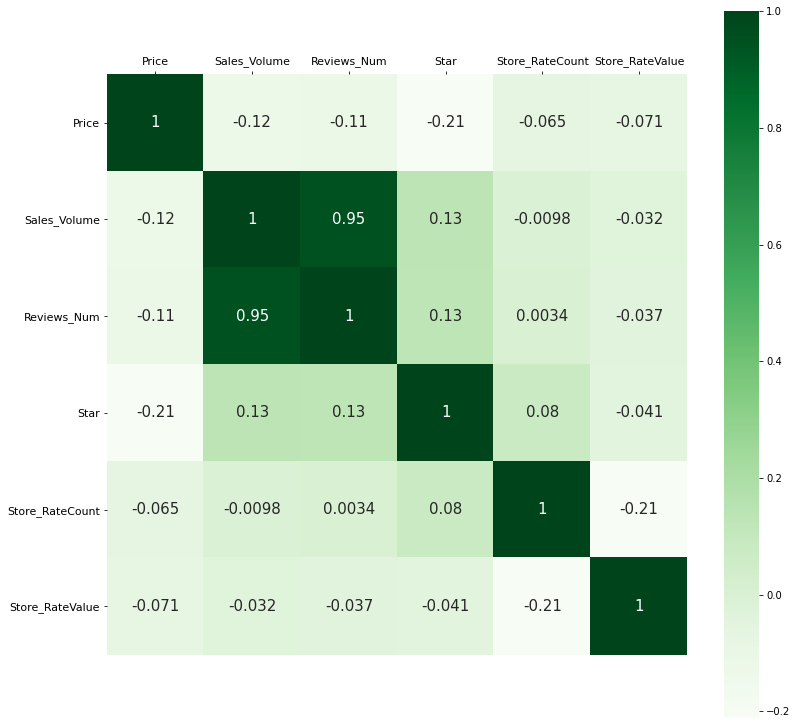

In [34]:
# 相關性資料視覺化
cor = df.corr()
fig, ax = plt.subplots(figsize=(13,13))
# 熱圖
sns.heatmap(cor, # 使用資料
            annot=True, # True: 顯示相關係數
            square=True, # 圖案是否為正方形
            cmap="Greens", # 顏色主題
            ax=ax, # 軸
            annot_kws={"size":15}) # 相關係數字的樣式調整
            
# x 軸名稱放到上面
ax.xaxis.tick_top()
# 設定軸名稱方向與大小
ax.set_xticklabels(cor.index, rotation=0, fontsize=11)
ax.set_yticklabels(cor.index, rotation=0, fontsize=11)

In [35]:
# 安裝字體
!wget "https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip"
!unzip "NotoSansCJKtc-hinted.zip"
!mv NotoSansCJKtc-Regular.otf /usr/share/fonts/truetype/

--2020-04-12 07:17:00--  https://noto-website-2.storage.googleapis.com/pkgs/NotoSansCJKtc-hinted.zip
Resolving noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c07::80
Connecting to noto-website-2.storage.googleapis.com (noto-website-2.storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121247366 (116M) [application/zip]
Saving to: ‘NotoSansCJKtc-hinted.zip.1’

NotoSansCJKtc-hinte 100%[===================>] 115.63M  69.0MB/s    in 1.7s    

2020-04-12 07:17:02 (69.0 MB/s) - ‘NotoSansCJKtc-hinted.zip.1’ saved [121247366/121247366]

Archive:  NotoSansCJKtc-hinted.zip
replace LICENSE_OFL.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: LICENSE_OFL.txt         
  inflating: NotoSansCJKtc-Black.otf  
  inflating: NotoSansCJKtc-Bold.otf  
  inflating: NotoSansCJKtc-DemiLight.otf  
  inflating: NotoSansCJKtc-Light.otf  
  inflating: NotoSansCJKtc-Medium.otf  
  in

In [0]:
# 使用中文字體
import matplotlib.font_manager as fm
path = "/usr/share/fonts/truetype/NotoSansCJKtc-Regular.otf"
fontProp = fm.FontProperties(fname=path, size=10)

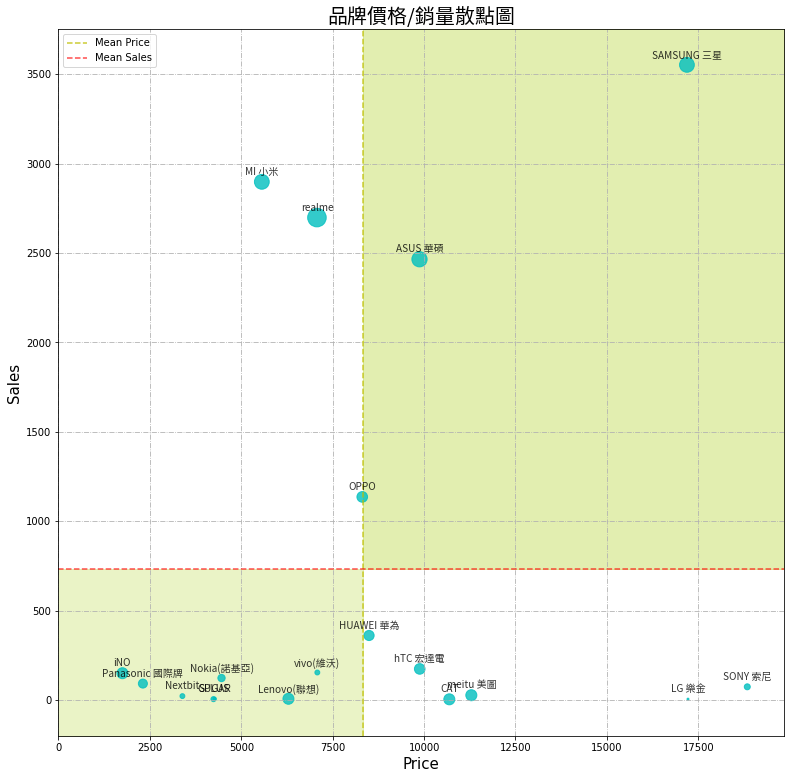

In [36]:
# 品牌價格/銷量散點圖
figB, axB = plt.subplots(figsize=(13,13))

xs = df_brand["Brand_Mean_Price"]
ys = df_brand["Brand_Sales"]
labels = df_brand.index
x_max = xs.max()+1000
y_max = ys.max()+200

plt.title("品牌價格/銷量散點圖", fontproperties=fontProp, size=20)
plt.xlabel("Price", size=15)
plt.ylabel("Sales", size=15)
plt.axis([0, x_max, -200, y_max])
plt.axvline(xs.mean(), color="y", linestyle="--", label="Mean Price", alpha=0.8) # 平均線
plt.axhline(ys.mean(), color="r", linestyle="--", label="Mean Sales", alpha=0.7) # 平均線

axB.fill_between([xs.mean(), x_max], ys.mean(), y_max, alpha=0.35, color="#add01f")
axB.fill_between([0, xs.mean()], -200, ys.mean(), alpha=0.25, color="#add01f")
s = (brand_process["Brand_Reviews_Num"]+brand_process["Brand_Mean_Star"])**2 # 散點大小
plt.scatter(xs, ys, s=s, color="c", alpha=0.8)
plt.grid(True, linestyle="-.") # 網格

for label, x, y in zip(labels, xs, ys):
  plt.annotate(label, (x, y), textcoords="offset points", xytext=(0, 15), ha="center", va="top", fontproperties=fontProp, alpha=0.8)

plt.legend()
plt.show()

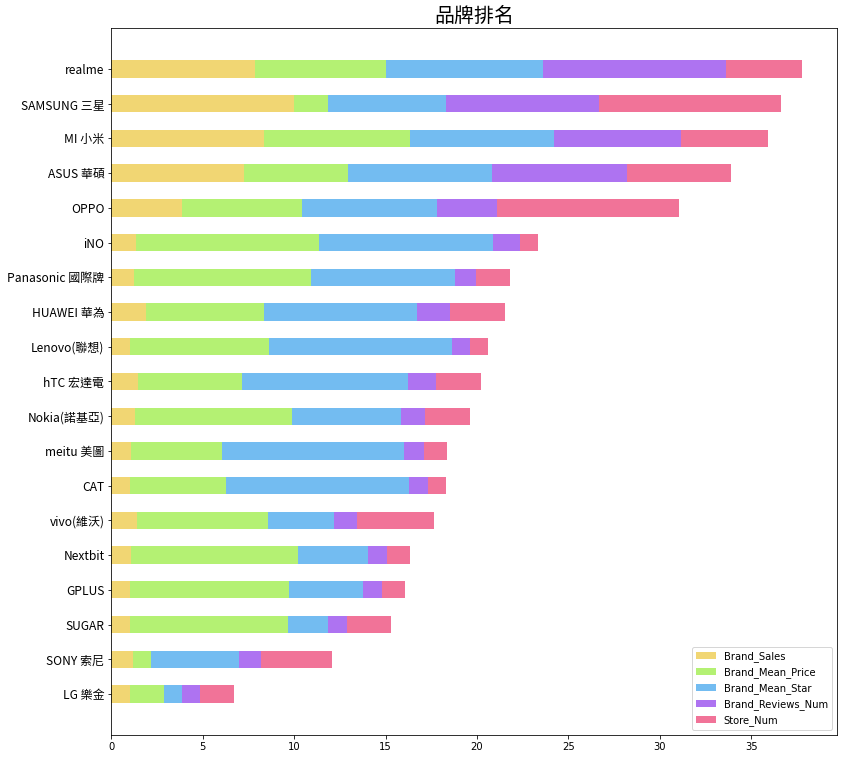

In [38]:
# 品牌排名
figRank, axRank = plt.subplots(figsize=(13,13))

plt.title("品牌排名" ,fontproperties=fontProp, size=20)
brand_process_copy = brand_process.sort_values(by="Nor_sum") 
x = brand_process_copy.index
color = ["#eecc50", "#a2ee50", "#50acee", "#9a50ee", "#ee507f"]
axRank.set_yticklabels(x, fontproperties=fontProp, size=12)

for i in range(5):
  plt.barh(x, 
           brand_process_copy[brand_process_copy.columns[i]], # 色塊寬
           color=color[i], # 顏色
           left=brand_process_copy[brand_process_copy.columns[:i]].sum(axis=1), # 從哪個座標開始(左邊開始算)
           label=brand_process_copy.columns[i], # 圖例名稱
           height=0.5, # 粗細度
           alpha=0.8) # 透明度

plt.legend() # 圖例